In [1]:
import os
from random import sample
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # Must be set before importing TF to supress messages
os.environ["CUDA_VISIBLE_DEVICES"]= '2'

import tensorflow as tf
from tensorflow.keras.callbacks import CSVLogger
import numpy as np
from utils.loader import DataLoader
from utils.tools import test_model, insert_attention_layer_in_keras
from utils.data_sampler import CustomDataGenerator, CustomIterator
from utils.configs import config
from typing import List
import pymf
import pandas as pd

def load_VGG_model(img_height: int, img_width: int, lr: int, loss: tf.keras.losses.Loss, metrics: List[str], trainable: True) -> tf.keras.Model:
    """ Loads VGG-16 model.

    Args:
        img_height (int): Image height.
        img_width (int): Image width.
        lr (int): Learning rate.
        loss (tf.keras.losses.Loss): Model loss.
        metrics (List[str]): Training metrics.
        trainable (True): Set if model weights should be kept frozen or not.

    Returns:
        tf.keras.Model: TensorFlow VGG-16 model.
    """
    model = tf.keras.applications.vgg16.VGG16(input_shape=(img_height, img_width, 3))
    model.trainable = trainable
    model.compile(optimizer=tf.keras.optimizers.Adam(lr, epsilon=0.1),
                loss=loss,
                metrics=metrics)

    return model

def test_model(model, test_set: CustomIterator, class_name) -> None:
    """ Test the passed model for its Top-1 accuracy on the passed test set.

    Args:
        model (Model): TensorFlow model.
        test_set (CustomIterator): Test set to test on.
    """
    test_set.reset()
    pred = model.predict(test_set, steps=test_set.n//test_set.batch_size, verbose=0)
    pred = np.argmax(pred, axis=-1)
    
    print('Computing accuracy...')
    accuracy = np.sum(pred == test_set.class_indices[class_name])/len(pred)

    return accuracy

In [2]:
# Set configs
img_height = 224
img_width = 224
batch_size = 128

test_datagen = CustomDataGenerator(
                preprocessing_function=tf.keras.applications.vgg16.preprocess_input, dtype=tf.float32)

# Load ImageNet dataset with the VGG augmentation
loader = DataLoader(batch_size, (img_height, img_width))
test_set = loader.load_test_set(aug_test=test_datagen, set_batch_size=False)

Loading test set...
Found 48238 images belonging to 1000 classes.


In [3]:
train_datagen = CustomDataGenerator(
                horizontal_flip=True,
                validation_split=0.1,
                preprocessing_function=tf.keras.applications.vgg16.preprocess_input, dtype=tf.float32)
train_set = loader.load_train_set(aug_train=train_datagen, class_mode='categorical', shuffle=True)

Loading train set...
Found 1153101 images belonging to 1000 classes.


In [3]:
# Load pre-trained VGG-16 model
tf.keras.backend.clear_session()
model = tf.keras.models.load_model('models/vgg_trained')
model.trainable = False

# Get layer kernel
kernel = model.get_layer('block4_conv3').kernel
flat_kernel = tf.reshape(kernel, [-1, kernel.shape[-1]]).numpy()

In [4]:
p_mat_dict = {}

for dim in [17, 42, 90, 256]:
    # Get projection matrix via SNMF
    n_comp = dim

    nmf = pymf.SNMF(flat_kernel, num_bases=n_comp)
    nmf.factorize(niter=400)
    p_mat = nmf.H

    p_mat_dict[dim] = p_mat

In [7]:
# Compile model
model.compile(optimizer=tf.keras.optimizers.Adam(3e-4),
                loss=tf.keras.losses.CategoricalCrossentropy(),
                metrics=['accuracy'])

In [4]:
classes = ['n01534433', 'n01608432', 'n01806143', 'n01820546', 'n01833805', 'n01855672', 'n02012849', 'n03887697', 'n03207941','n02906734', 'n04131690', 'n03775546', 'n04553703', 'n03207743'] 
ave = ['n01534433', 'n01608432', 'n01806143', 'n01820546', 'n01833805', 'n01855672', 'n02012849'] 
kitchen = ['n03887697', 'n03207941','n02906734', 'n04131690', 'n03775546', 'n04553703', 'n03207743']

In [11]:
nmf = pymf.SNMF(flat_kernel, num_bases=17)
nmf.factorize(niter=400)
p_mat = nmf.H

In [ ]:
model = tf.keras.models.load_model('models/vgg_trained')
model.trainable = False
model = insert_attention_layer_in_keras(p_mat, model, ['block5_conv1'])

model.load_weights(f'models/baselines/{17}/model_weights')
test_set.set_target_sampling(['n01608432'], [1])
acc_val = test_model(model, test_set, 'n01608432')
print(acc_val) 
a = model.get_layer('attention_block5_conv1').seeds.numpy()
print(np.sum(a==0)/(a.shape[0]*a.shape[1]))

In [7]:
import matplotlib.pyplot as plt

(0.0, 2.0)

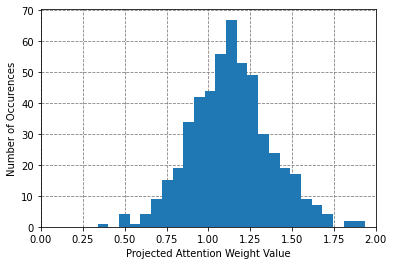

In [8]:
# a = model.get_layer('attention_block5_conv1').seeds.numpy()
# print(np.sum(a==0)/(a.shape[0]*a.shape[1]))

pj = model.get_layer('attention_block5_conv1').seeds @ model.get_layer('attention_block5_conv1').projection_mat + model.get_layer('attention_block5_conv1').bias
fig2, ax2 = plt.subplots()
ax2.set_axisbelow(True)
ax2.yaxis.grid(color='gray', linestyle='dashed')
ax2.xaxis.grid(color='gray', linestyle='dashed')
ax2.hist(pj.numpy().tolist(), bins=25)
ax2.set_xlabel('Projected Attention Weight Value')
ax2.set_ylabel('Number of Occurences')
ax2.set_xlim([0, 2])
#fig2.savefig(f'e-2_base.png')

In [ ]:
model = tf.keras.models.load_model('models/vgg_trained')
model.trainable = False
nmf = pymf.SNMF(flat_kernel, num_bases=17)
nmf.factorize(niter=400)
p_mat = nmf.H
model = insert_attention_layer_in_keras(p_mat, model, ['block5_conv1'])
model.load_weights(f'models/task_models/n01534433/{17}/model_weights')

pj = model.get_layer('attention_block5_conv1').seeds @ model.get_layer('attention_block5_conv1').projection_mat + model.get_layer('attention_block5_conv1').bias
fig2, ax2 = plt.subplots()
ax2.set_axisbelow(True)
ax2.yaxis.grid(color='gray', linestyle='dashed')
ax2.xaxis.grid(color='gray', linestyle='dashed')
ax2.hist(pj.numpy().tolist(), bins=18)
ax2.set_xlabel('(normalised) frequency * rank')
ax2.set_ylabel('Number of Occurences')
ax2.set_xlim([0, 2])

In [ ]:
sparsity = {}
b = [0, 40, 18, 12]
for i in [17,42,90]:
    model = tf.keras.models.load_model('models/vgg_trained')
    model.trainable = False
    nmf = pymf.SNMF(flat_kernel, num_bases=i)
    nmf.factorize(niter=400)
    p_mat = nmf.H
    model = insert_attention_layer_in_keras(p_mat, model, ['block5_conv1'])
    model.load_weights(f'models/task_models/n01534433/{i}/model_weights')
    a = model.get_layer('attention_block5_conv1').seeds.numpy()
    sparsity[f'{i}']=np.sum(a==0)/(a.shape[0]*a.shape[1])

    pj = model.get_layer('attention_block5_conv1').seeds @ model.get_layer('attention_block5_conv1').projection_mat + model.get_layer('attention_block5_conv1').bias
    fig2, ax2 = plt.subplots()
    ax2.set_axisbelow(True)
    ax2.yaxis.grid(color='gray', linestyle='dashed')
    ax2.xaxis.grid(color='gray', linestyle='dashed')
    ax2.hist(pj.numpy().tolist(), bins=18)
    ax2.set_xlabel('(normalised) frequency * rank')
    ax2.set_ylabel('Number of Occurences')
    ax2.set_xlim([0, 2])
    #fig2.savefig(f'e-{i}.png')

In [ ]:
acc = pd.DataFrame(columns=['group', 'class', 17, 42, 90, 256])
acc_baseline = pd.DataFrame(columns=['group', 'class', 17, 42, 90, 256])

for cl in classes:
    acc = acc.append({'group':'ave' if cl in ave else 'kitchen', 'class':cl, 17:0, 42:0, 90:0, 256:0}, ignore_index=True)
    acc_baseline = acc_baseline.append({'group':'ave' if cl in ave else 'kitchen', 'class':cl, 17:0, 42:0, 90:0, 256:0}, ignore_index=True)

# Begin the tests for each class (baseline)
for dim in [17, 42, 90, 256]:
    model = tf.keras.models.load_model('models/vgg_trained')
    model.trainable = False
    model = insert_attention_layer_in_keras(p_mat_dict[dim], model, ['block5_conv1'])

    model.load_weights(f'models/baselines/baseline{dim}')
    for cl in classes:
        test_set.set_target_sampling([cl], [1])
        acc_val = test_model(model, test_set, cl)
        acc_baseline.loc[classes.index(cl), dim] = acc_val

# Begin the tests for each class (target)
for dim in [17, 42, 90, 256]:
    model = tf.keras.models.load_model('models/vgg_trained')
    model.trainable = False
    model = insert_attention_layer_in_keras(p_mat_dict[dim], model, ['block5_conv1'])

    model.load_weights(f'models/task_models/{cl}/{dim}/model_weights', )
    for cl in classes:
        test_set.set_target_sampling([cl], [1])
        acc_val = test_model(model, test_set, cl)
        acc.loc[classes.index(cl), dim] = acc_val

Sensitivity model

In [116]:
def hr_model(model, test_set: CustomIterator, cl) -> None:
    """ Test the passed model for its hit rate on the passed test set.

    Args:
        model (Model): TensorFlow model.
        test_set (CustomIterator): Test set to test on.
    """
    test_set.reset()
    pred = model.predict(test_set, steps=test_set.n//test_set.batch_size, verbose=1)
    pred = np.argmax(pred, axis=-1)
    cls = np.array(test_set.classes)
    
    print('Computing rates...')
    fp_val = np.sum(cls[np.where(pred==test_set.class_indices[cl])[0]]==test_set.class_indices[cl])/len(pred)
    hr_val = np.sum(cls[np.where(pred==test_set.class_indices[cl])[0]]!=test_set.class_indices[cl])/len(pred)

    return fp_val, hr_val

In [ ]:
test_set.reset_target_sampling()
hr = pd.DataFrame(columns=['group', 'class', 17, 42, 90, 256])
hr_baseline = pd.DataFrame(columns=['group', 'class', 17, 42, 90, 256])
fp = pd.DataFrame(columns=['group', 'class', 17, 42, 90, 256])
fp_baseline = pd.DataFrame(columns=['group', 'class', 17, 42, 90, 256])

for cl in classes:
    hr = hr.append({'group':'ave' if cl in ave else 'kitchen', 'class':cl, 17:0, 42:0, 90:0, 256:0}, ignore_index=True)
    hr_baseline = hr_baseline.append({'group':'ave' if cl in ave else 'kitchen', 'class':cl, 17:0, 42:0, 90:0, 256:0}, ignore_index=True)
    fp = fp.append({'group':'ave' if cl in ave else 'kitchen', 'class':cl, 17:0, 42:0, 90:0, 256:0}, ignore_index=True)
    fp_baseline = fp_baseline.append({'group':'ave' if cl in ave else 'kitchen', 'class':cl, 17:0, 42:0, 90:0, 256:0}, ignore_index=True)

# Begin the tests for each class (baseline)
for dim in [17, 42, 90, 256]:
    model = tf.keras.models.load_model('models/vgg_trained')
    model.trainable = False
    model = insert_attention_layer_in_keras(p_mat_dict[dim], model, ['block5_conv1'])

    model.load_weights(f'models/baselines/baseline{dim}')
    for cl in classes[:2]:
        fp_val, hr_val = hr_model(model, test_set, cl)
        fp_baseline.loc[classes.index(cl), dim] = fp_val
        hr_baseline.loc[classes.index(cl), dim] = hr_val

# Begin the tests for each class (target)
for dim in [17, 42, 90, 256]:
    model = tf.keras.models.load_model('models/vgg_trained')
    model.trainable = False
    model = insert_attention_layer_in_keras(p_mat_dict[dim], model, ['block5_conv1'])

    model.load_weights(f'models/task_models/{cl}/{dim}/model_weights', )
    for cl in classes[:2]:
        fp_val, hr_val = hr_model(model, test_set, cl)
        fp.loc[classes.index(cl), dim] = fp_val
        hr.loc[classes.index(cl), dim] = hr_val

In [ ]:
model.get_layer('attention_block5_conv1').seeds@model.get_layer('attention_block5_conv1').projection_mat + model.get_layer('attention_block5_conv1').bias